## 範例重點
* 學習如何在 keras 中加入 BatchNorm
* 知道有無 BN 對訓練的影響
* 比較 BN 在不同 batch size 下的效果

In [5]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [6]:
train, test = keras.datasets.cifar10.load_data()

In [7]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [8]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model




In [10]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 30
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [11]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]





Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               

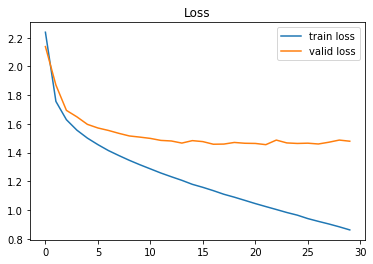

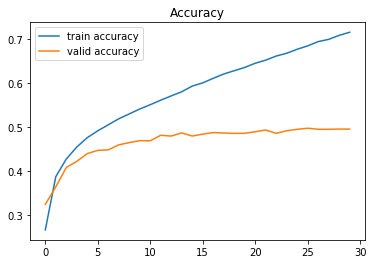

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [24]:
def build_mlp_before_act(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [25]:
def build_mlp_after_input(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    x = BatchNormalization()(input_layer)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [31]:
LEARNING_RATE = 1e-1
EPOCHS = 50
BATCH_SIZE = [2, 16, 32, 128, 256]
MOMENTUM = 0.95

In [32]:
results = {}

for bn in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with BN = %.6f" % (bn))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bn, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-BN-%s" % str(bn)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with BN = 2.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch 

Epoch 46/50
50000/50000 [==============================] - 33s 651us/step - loss: 1.6315 - acc: 0.4412 - val_loss: 1.6067 - val_acc: 0.4421
Epoch 47/50
50000/50000 [==============================] - 33s 652us/step - loss: 1.6365 - acc: 0.4407 - val_loss: 1.6967 - val_acc: 0.3935
Epoch 48/50
50000/50000 [==============================] - 33s 654us/step - loss: 1.6393 - acc: 0.4355 - val_loss: 1.6106 - val_acc: 0.4414
Epoch 49/50
50000/50000 [==============================] - 33s 652us/step - loss: 1.6252 - acc: 0.4434 - val_loss: 1.6434 - val_acc: 0.4490
Epoch 50/50
50000/50000 [==============================] - 33s 655us/step - loss: 1.6285 - acc: 0.4417 - val_loss: 1.7165 - val_acc: 0.4313
Experiment with BN = 32.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
______________________________________________________

Epoch 44/50
50000/50000 [==============================] - 17s 344us/step - loss: 1.2476 - acc: 0.5640 - val_loss: 1.5325 - val_acc: 0.4905
Epoch 45/50
50000/50000 [==============================] - 17s 345us/step - loss: 1.2478 - acc: 0.5658 - val_loss: 1.4903 - val_acc: 0.5021
Epoch 46/50
50000/50000 [==============================] - 17s 345us/step - loss: 1.2473 - acc: 0.5642 - val_loss: 1.5958 - val_acc: 0.4722
Epoch 47/50
50000/50000 [==============================] - 17s 344us/step - loss: 1.2377 - acc: 0.5687 - val_loss: 1.4827 - val_acc: 0.4860
Epoch 48/50
50000/50000 [==============================] - 17s 344us/step - loss: 1.2377 - acc: 0.5680 - val_loss: 1.5947 - val_acc: 0.4709
Epoch 49/50
50000/50000 [==============================] - 17s 345us/step - loss: 1.2292 - acc: 0.5683 - val_loss: 1.4659 - val_acc: 0.4894
Epoch 50/50
50000/50000 [==============================] - 17s 346us/step - loss: 1.2320 - acc: 0.5694 - val_loss: 1.4992 - val_acc: 0.4881
Experiment with BN =

50000/50000 [==============================] - 4s 84us/step - loss: 0.5350 - acc: 0.8056 - val_loss: 2.1046 - val_acc: 0.4982
Epoch 41/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.5274 - acc: 0.8088 - val_loss: 2.4039 - val_acc: 0.4636
Epoch 42/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.5087 - acc: 0.8151 - val_loss: 2.3396 - val_acc: 0.4817
Epoch 43/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.5058 - acc: 0.8145 - val_loss: 2.3317 - val_acc: 0.4766
Epoch 44/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.4896 - acc: 0.8216 - val_loss: 2.2871 - val_acc: 0.4906
Epoch 45/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.4724 - acc: 0.8276 - val_loss: 2.3186 - val_acc: 0.4803
Epoch 46/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.4646 - acc: 0.8305 - val_loss: 2.2855 - val_acc: 0.4848
Epoch 47/50
50000/50000 [=====================

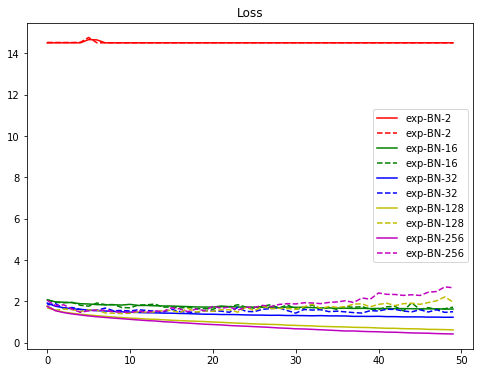

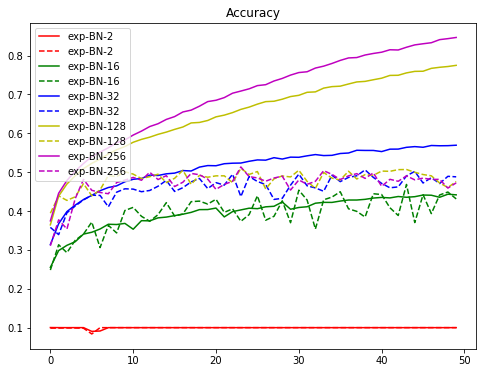

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [19]:
LEARNING_RATE = 1e-1
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95

In [26]:
results2 = {}
keras.backend.clear_session() # 把舊的 Graph 清掉
print("Experiment with normal")
model2 = build_mlp(input_shape=x_train.shape[1:])
model2.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model2.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model2.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss2 = model2.history.history["loss"]
valid_loss2 = model2.history.history["val_loss"]
train_acc2 = model2.history.history["acc"]
valid_acc2 = model2.history.history["val_acc"]

exp_name_tag = "normal"
results2[exp_name_tag] = {'train-loss': train_loss2,
                         'valid-loss': valid_loss2,
                         'train-acc': train_acc2,
                         'valid-acc': valid_acc2}

keras.backend.clear_session() # 把舊的 Graph 清掉
print("Experiment with BN_before_act")
model2 = build_mlp_before_act(input_shape=x_train.shape[1:])
model2.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model2.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model2.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss2 = model2.history.history["loss"]
valid_loss2 = model2.history.history["val_loss"]
train_acc2 = model2.history.history["acc"]
valid_acc2 = model2.history.history["val_acc"]

exp_name_tag = "BN_before_act"
results2[exp_name_tag] = {'train-loss': train_loss2,
                         'valid-loss': valid_loss2,
                         'train-acc': train_acc2,
                         'valid-acc': valid_acc2}

keras.backend.clear_session() # 把舊的 Graph 清掉
print("Experiment with BN_after_input")
model2 = build_mlp_after_input(input_shape=x_train.shape[1:])
model2.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model2.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model2.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss2 = model2.history.history["loss"]
valid_loss2 = model2.history.history["val_loss"]
train_acc2 = model2.history.history["acc"]
valid_acc2 = model2.history.history["val_acc"]

exp_name_tag = "BN_after_input"
results2[exp_name_tag] = {'train-loss': train_loss2,
                         'valid-loss': valid_loss2,
                         'train-acc': train_acc2,
                         'valid-acc': valid_acc2}


Experiment with normal
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 

50000/50000 [==============================] - 4s 78us/step - loss: 0.5828 - acc: 0.7892 - val_loss: 2.3219 - val_acc: 0.4776
Epoch 49/50
50000/50000 [==============================] - 4s 78us/step - loss: 0.5708 - acc: 0.7939 - val_loss: 2.4732 - val_acc: 0.4718
Epoch 50/50
50000/50000 [==============================] - 4s 78us/step - loss: 0.5525 - acc: 0.8000 - val_loss: 2.6265 - val_acc: 0.4670
Experiment with BN_after_input
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense) 

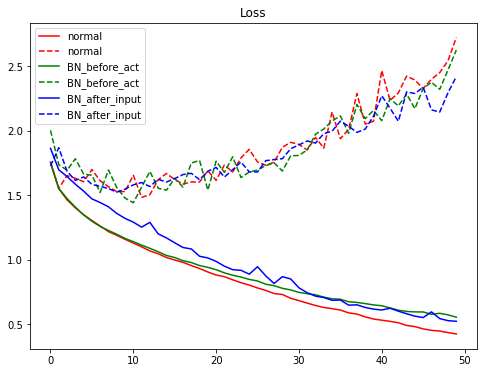

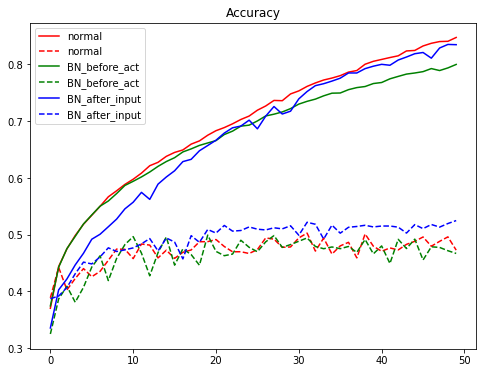

In [27]:
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results2.keys()):
    plt.plot(range(len(results2[cond]['train-loss'])),results2[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results2[cond]['valid-loss'])),results2[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results2.keys()):
    plt.plot(range(len(results2[cond]['train-acc'])),results2[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results2[cond]['valid-acc'])),results2[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()